In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs231n/assignments/CS231N_project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/My Drive/cs231n/assignments/CS231N_project//cs231n/datasets/'
/content
bash: get_datasets.sh: No such file or directory
/content/drive/My Drive/cs231n/assignments/CS231N_project


In [7]:
# Run this cell to see sample outputs.
from IPython.display import Image


In [8]:
# Setup cell.
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cs231n.gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

answers = dict(np.load('gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4597536.01it/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 136176.83it/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272463.75it/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11517852.94it/s]


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw



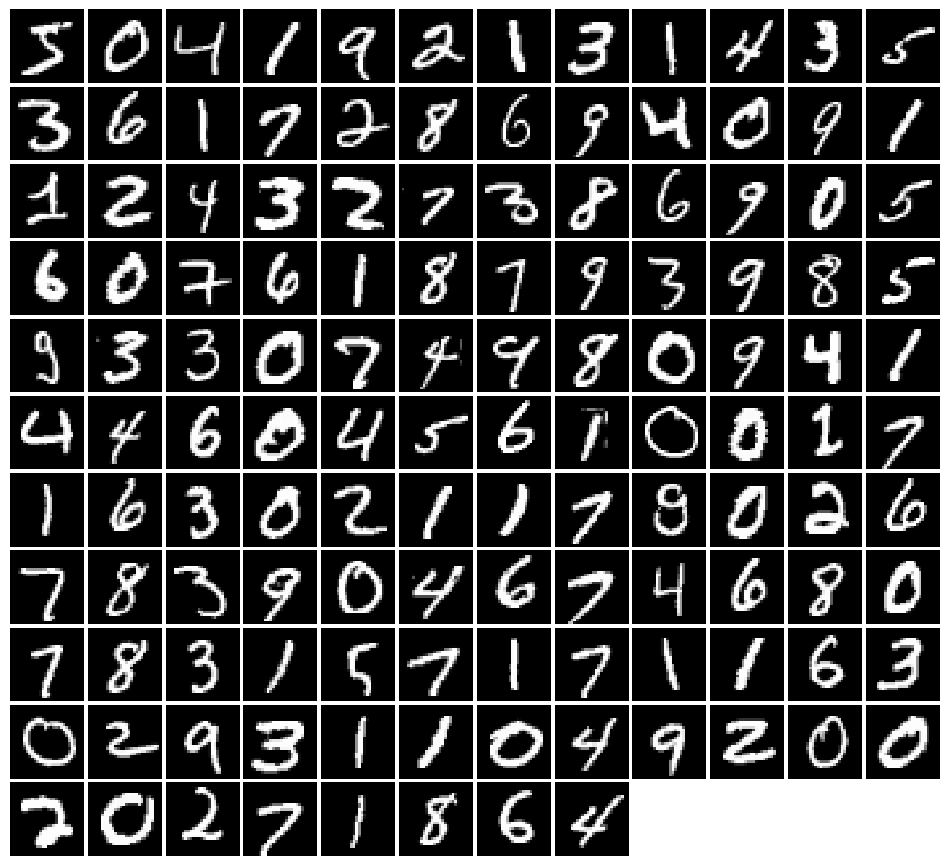

In [9]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

iterator = iter(loader_train)
imgs, labels = next(iterator)
imgs = imgs.view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise




In [10]:
from cs231n.gan_pytorch import sample_noise

def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')

test_sample_noise()

All tests passed!


In [11]:
from cs231n.gan_pytorch import Flatten, Unflatten, initialize_weights

In [12]:
from cs231n.gan_pytorch import w_discriminator_loss, w_generator_loss
from cs231n.gan_pytorch import discriminator, generator
from cs231n.gan_pytorch import get_optimizer, run_a_gan

D_W = discriminator().type(dtype)
G_W = generator().type(dtype)

D_W_solver = get_optimizer(D_W)
G_W_solver = get_optimizer(G_W)

images = run_a_gan(
    D_W,
    G_W,
    D_W_solver,
    G_W_solver,
    w_discriminator_loss,
    w_generator_loss,
    loader_train
)

Iter: 0, D: -0.02679, G:-0.04222
Iter: 250, D: -93.05, G:30.49
Iter: 500, D: 4.854, G:-174.8
Iter: 750, D: -7.369, G:-65.85
Iter: 1000, D: 2.932, G:-25.11
Iter: 1250, D: -1.027, G:13.59
Iter: 1500, D: -0.6007, G:-8.732
Iter: 1750, D: 9.179, G:-119.3
Iter: 2000, D: -2.065e+04, G:2.47e+04
Iter: 2250, D: -3.601e+05, G:-4.131e+04
Iter: 2500, D: -5.253e+05, G:-6.146e+05
Iter: 2750, D: -5.466e+06, G:1.286e+06
Iter: 3000, D: -8.482e+06, G:4.38e+06
Iter: 3250, D: -5.665e+06, G:2.682e+06
Iter: 3500, D: -1.075e+07, G:3.245e+06
Iter: 3750, D: -2.201e+07, G:1.282e+07


Iter: 0


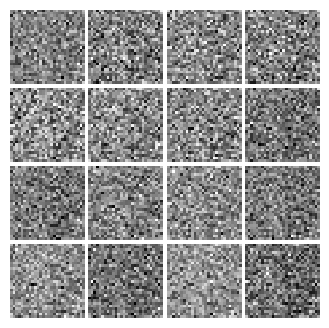


Iter: 250


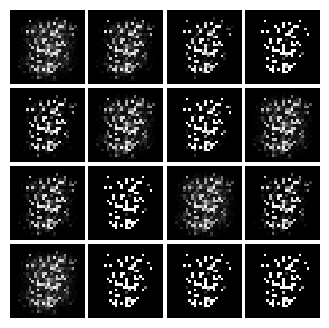


Iter: 500


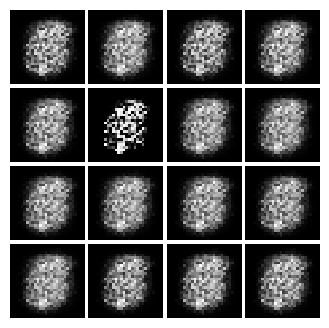


Iter: 750


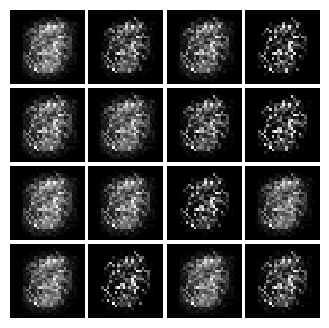


Iter: 1000


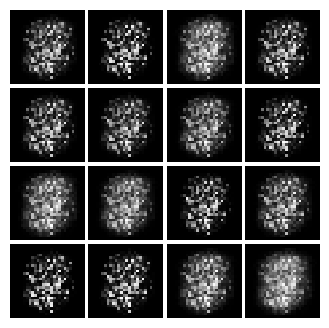


Iter: 1250


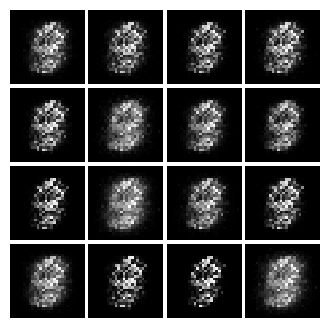


Iter: 1500


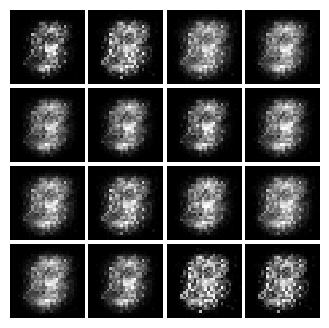


Iter: 1750


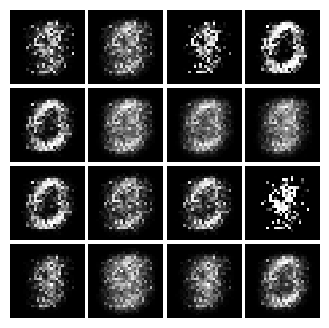


Iter: 2000


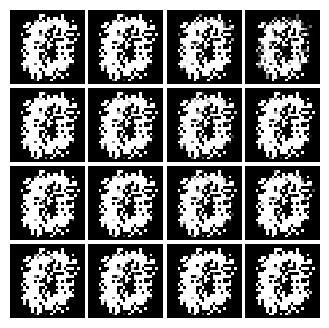


Iter: 2250


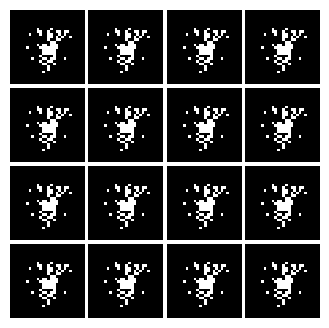


Iter: 2500


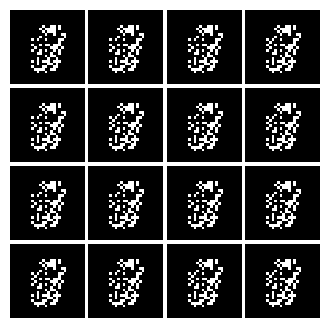


Iter: 2750


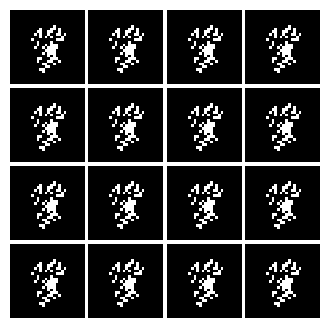


Iter: 3000


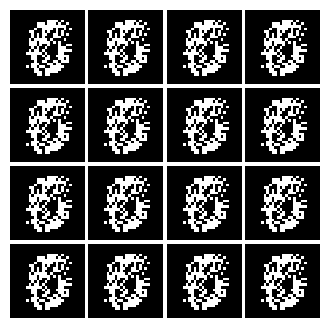


Iter: 3250


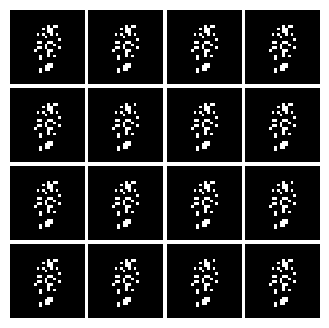


Iter: 3500


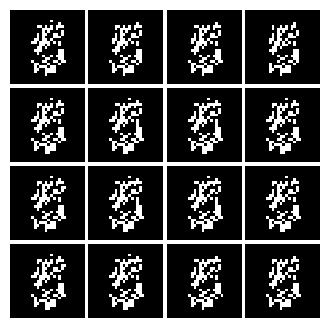


Iter: 3750


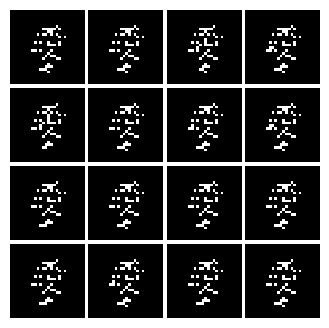

In [13]:
numIter = 0
for img in images:

    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

DCGAN final image:


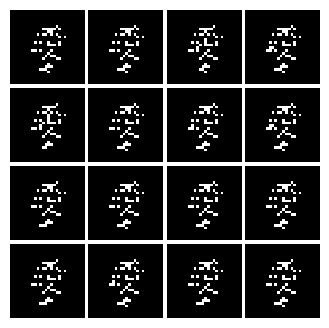

In [ ]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()

In [14]:
from cs231n.gan_pytorch import build_dc_generator, build_dc_classifier
from cs231n.gan_pytorch import w_discriminator_loss, w_generator_loss
from cs231n.gan_pytorch import get_optimizer, run_a_wgan

D_DC = build_dc_classifier(batch_size).type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_wgan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    w_discriminator_loss,
    w_generator_loss,
    loader_train,
    num_epochs=5,
    D_step=5,
    gradient_clip=7.5e-8
)

Iter: 0, D: -0.1583, G:-0.0673
Iter: 250, D: -0.1483, G:-6.19
Iter: 500, D: -0.1935, G:-9.583
Iter: 750, D: -0.5893, G:-15.67
Iter: 1000, D: -0.5161, G:-12.14
Iter: 1250, D: 1.342, G:-27.3
Iter: 1500, D: 1.026, G:-25.66
Iter: 1750, D: -2.81, G:-25.48


Iter: 0


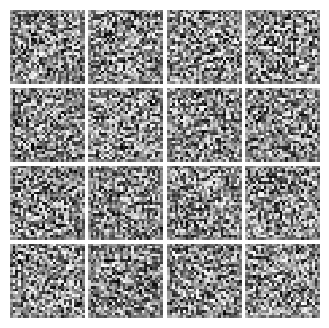


Iter: 250


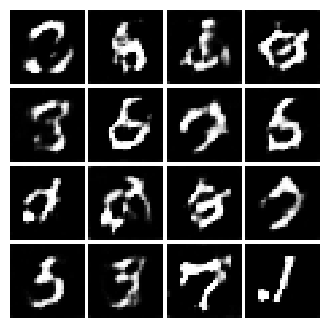


Iter: 500


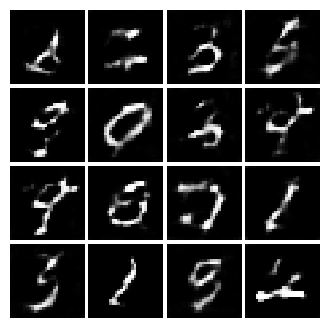


Iter: 750


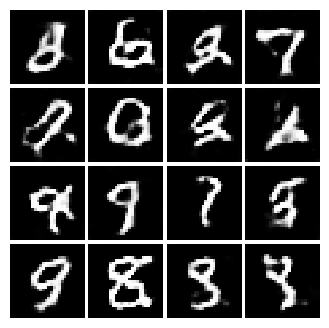


Iter: 1000


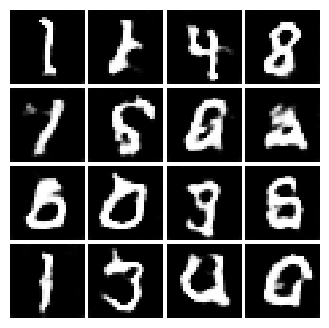


Iter: 1250


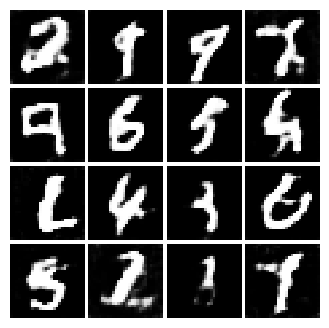


Iter: 1500


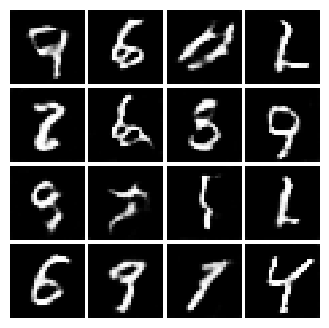


Iter: 1750


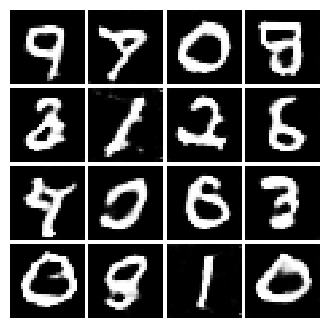

In [ ]:
numIter = 0
for img in images:

    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

DCGAN final image:


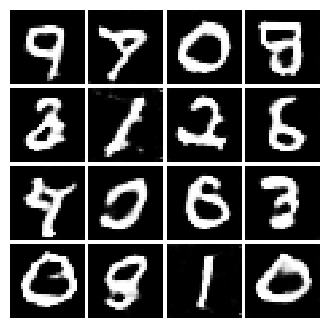

In [ ]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()

In [ ]:
from cs231n.gan_pytorch import build_dc_generator, build_dc_classifier
from cs231n.gan_pytorch import w_discriminator_loss, w_generator_loss
from cs231n.gan_pytorch import get_optimizer, run_a_wgan

D_DC = build_dc_classifier(batch_size).type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_wgan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    w_discriminator_loss,
    w_generator_loss,
    loader_train,
    num_epochs=5,
    D_step=5
    # gradient_clip=7.5e-8,
    # weight_clip=0.001
)

Iter: 0, D: -19.74, G:16.35
Iter: 250, D: -6.977e+04, G:-6.147e+05
Iter: 500, D: -1.045e+06, G:4.779e+05
Iter: 750, D: -1.541e+04, G:-4.239e+04
Iter: 1000, D: -3.01e+04, G:3.349e+05
Iter: 1250, D: -1.699e+05, G:-8.074e+05
Iter: 1500, D: -2.906e+05, G:-2.858e+06
Iter: 1750, D: -1.413e+06, G:4.634e+05


Iter: 0


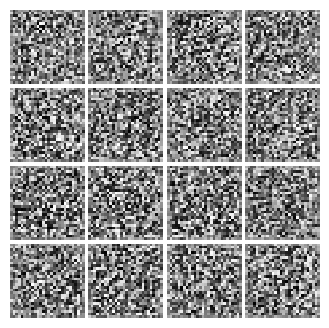


Iter: 250


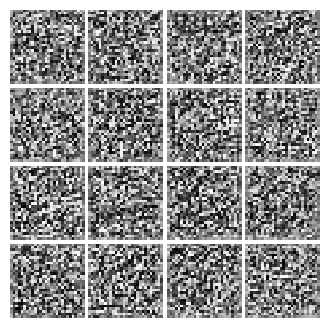


Iter: 500


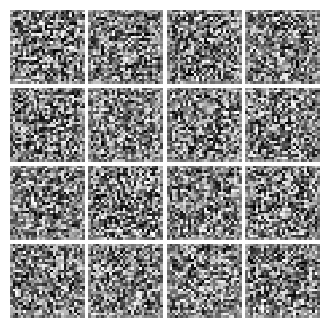


Iter: 750


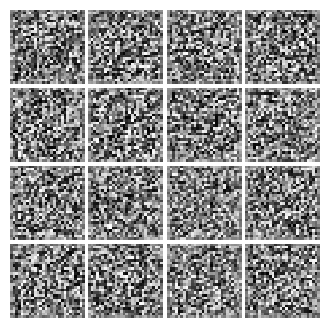


Iter: 1000


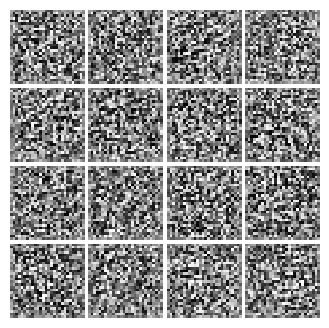


Iter: 1250


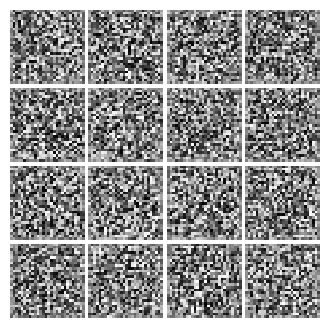


Iter: 1500


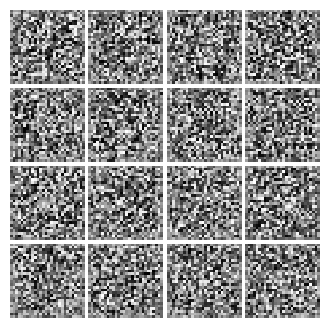


Iter: 1750


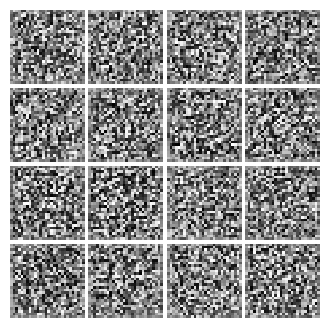

In [ ]:
numIter = 0
for img in images:

    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

DCGAN final image:


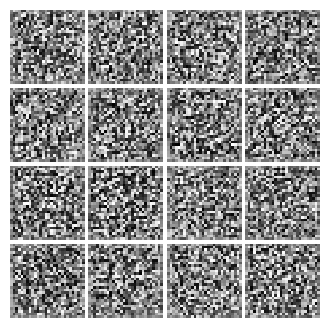

In [ ]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()